# Run experiment on 1 dataset (domain)

To use this notebook, repeat these steps below for all datasets (domains):
- Specify `DOMAIN` with the dataset (domain) you would like to run quality control on
- Run the notebook and save its results with `USE_ORIGINAL_CONTENT_IMAGES=True`
- Run the notebook and save its results with `USE_ORIGINAL_CONTENT_IMAGES=False`
  
After collecting all results, run the notebook `visualize_fidelity.ipynb` to visualize the final results

In [1]:
DOMAIN = "birds"
USE_ORIGINAL_CONTENT_IMAGES = False # if True, all stylized images are replaced with content images
WITH_BIAS = False # if True, dataset are splitted into train and test with group bias
WITH_SMOOTHING = False
WITH_AUGMENTATION = True

In [2]:
import os
import random
N_TRIALS = 100
ALL_CLASS_NAMES = os.listdir(f'/kaggle/input/kaggle-dataset-stf/{DOMAIN}/content')
ALL_STYLE_NAMES = os.listdir(f'/kaggle/input/kaggle-dataset-stf/{DOMAIN}/styles')

# ---------- Generate new experiments list -----------
EACH_TRIAL_CLASS_NAMES = []
EACH_TRIAL_STYLE_NAMES = []
for n_trial in range(N_TRIALS):
    CLASS_NAMES = random.sample(ALL_CLASS_NAMES, 3)
    STYLE_NAMES = random.sample(ALL_STYLE_NAMES, 3)
    EACH_TRIAL_CLASS_NAMES.append(CLASS_NAMES)
    EACH_TRIAL_STYLE_NAMES.append(STYLE_NAMES)

## About EfficientNet-V2

EfficientNetV2 is a new family of convolutional networks that have faster training speed and better parameter efficiency than previous models. To develop these models, a combination of training-aware neural architecture search and scaling was used to jointly optimize
training speed and parameter efficiency. The models were searched from the search space enriched
with new ops such as Fused-MBConv. Experiments show that EfficientNetV2 models train much faster than state-of-the-art models while being up to 6.8x smaller.

With progressive learning, our EfficientNetV2 significantly outperforms previous models on ImageNet and CIFAR/Cars/Flowers datasets. By
pretraining on the same ImageNet21k, EfficientNetV2 achieves 87.3% top-1 accuracy on ImageNet ILSVRC2012, outperforming the recent ViT by 2.0% accuracy while training 5x-11x faster using the same computing resources

![Screenshot from 2022-08-26 21-20-36.png](https://miro.medium.com/max/922/1*rZtosLGF5qx1MmRILfKgdA.png)

<div class="alert alert-block alert-success" style="font-size:25px">
1. Imports, constants, dependencies
</div>

In [3]:
from typing import List

try:
    import pylibjpeg
except:
    # Offline dependencies for jpeg data extraction and torchvisioin 0.13 (required for EfficientNetV2)
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !cp ../input/rsna-2022-whl/efficientnet_v2_s-dd5fe13b.pth  /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

Processing /kaggle/input/rsna-2022-whl/pydicom-2.3.0-py3-none-any.whl
Processing /kaggle/input/rsna-2022-whl/pylibjpeg-1.4.0-py3-none-any.whl
Processing /kaggle/input/rsna-2022-whl/python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
pydicom is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Processing /kaggle/input/rsna-2022-whl/torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl
Processing /kaggle/input/rsna-2022-whl/torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

In [4]:
import gc
import os

import cv2
import matplotlib.pyplot as plt
from scipy.stats import gmean
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, KFold
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


# Effnet
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT

EFFNET_CHECKPOINTS_PATH = '../input/awa-detection-checkpoints'

EPOCHS = 7

EFFNET_MAX_TRAIN_BATCHES = 10000
EFFNET_MAX_EVAL_BATCHES = 1000
ONE_CYCLE_MAX_LR = 0.0004
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 500
N_MODELS_FOR_INFERENCE = 2

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 4
else:
    BATCH_SIZE = 2
N_FOLDS = 5

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm
#######################################################
#               Define Transforms
#######################################################

#To define an augmentation pipeline, you need to create an instance of the Compose class.
#As an argument to the Compose class, you need to pass a list of augmentations you want to apply. 
#A call to Compose will return a transform function that will perform image augmentation.
#(https://albumentations.ai/docs/getting_started/image_augmentation/)

image_size = 512
train_transforms = A.Compose([
        A.SmallestMaxSize(max_size=image_size),
        A.CenterCrop(height=image_size, width=image_size),
        A.HorizontalFlip(p=0.5),
        A.ImageCompression(quality_lower=99, quality_upper=100),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
#         A.Resize(image_size, image_size),
        A.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
        ToTensorV2(),
    ])

# A.Compose(
#     [
#         A.SmallestMaxSize(max_size=160),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
#         A.RandomCrop(height=128, width=128),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#         A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
#         ToTensorV2(),
#     ]
# )

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=image_size),
        A.CenterCrop(height=image_size, width=image_size),
        ToTensorV2(),
    ]
)

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/dropout/cutout.py:52: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  FutureWarning,


<div class="alert alert-block alert-success" style="font-size:25px">
    2. Animals with Attributes 2 dataset
</div>

In [6]:
# Pick all classes from the domain folder
print('All classes name:', ALL_CLASS_NAMES)
print()
print('All styles name:', ALL_STYLE_NAMES)

All classes name: ['RED_FACED_WARBLER', 'PURPLE_MARTIN', 'LOGGERHEAD_SHRIKE', 'BORNEAN_PHEASANT', 'ROCK_DOVE', 'PUFFIN', 'ALTAMIRA_YELLOWTHROAT', 'EMPEROR_PENGUIN', 'POMARINE_JAEGER', 'GREEN_JAY', 'SRI_LANKA_BLUE_MAGPIE', 'APAPANE', 'WILSONS_BIRD_OF_PARADISE', 'BANDED_PITA', 'RAINBOW_LORIKEET', 'AMERICAN_GOLDFINCH', 'WATTLED_LAPWING', 'MOURNING_DOVE', 'AZARAS_SPINETAIL', 'CRESTED_OROPENDOLA']

All styles name: ['water_lilles', 'thunder', 'aurora', 'cloud', 'hurricane', 'analytical_art', 'rayonism', 'american_barbizon_school', 'autumn_leaves', 'prehistorian_painting', 'swamp', 'abstract_illusionism', 'land_art', 'arts_and_crafts_movement', 'meadow', 'chinese_art', 'american_impressionism', 'wave', 'dawn', 'fauvism_painting']


In [7]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed(2022)

In [8]:
from torch.utils.data import Dataset
class AWADataset(Dataset):
    def __init__(self, image_paths, orig_image_paths, labels, styles, transform=False, known_styles=False):
        self.image_paths = image_paths
        self.orig_image_paths = orig_image_paths
        self.transform = transform
        self.known_styles = known_styles
        self.labels = labels
        self.styles = styles
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        orig_image_filepath = self.orig_image_paths[idx]
        if USE_ORIGINAL_CONTENT_IMAGES:
            image = cv2.imread(f'/kaggle/input/kaggle-dataset-stf/{DOMAIN}/content/{self.labels[idx]}/' + orig_image_filepath)
        else:
            image = cv2.imread(f'/kaggle/input/kaggle-dataset-stf/{DOMAIN}/stylized/{self.styles[idx]}_{self.labels[idx]}/' + image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if WITH_SMOOTHING:
            # Use GaussianBlur
            image = cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
        try:
            label = class_to_idx[self.labels[idx]]
        except:
            print(idx)
            print(self.labels[idx])
            print(class_to_idx)
            raise
        if self.transform is not None:
            image = self.transform(image=image)["image"].type(torch.float)
        
        if self.known_styles:
            style = style_to_idx[self.styles[idx]]
            return image, label, style
        else:
            return image, label

In [9]:
def bias_spliter(df, categories, styles, dominant_minority_ratio = 3, random_state=42, shuffle_styles = True): 
    """
    The method is taking a dataframe and it is generating a biased set. 

    @df - the dataframe that needs to be biased 
    @percentage - the percentage of samples from the dominant style of each category 
    @shuffle_styles - if True, then the style will be randomly selected for each category

    return: a biased dataframe which has a dominant style for each category

    """
    
    if shuffle_styles : 
        random.Random(random_state).shuffle(styles)
        
    
    chunks = []
    
    for index_style, style in enumerate(styles):
        for index_category, category in enumerate(categories): 
            
            style_category_df = df[(df['STYLE'] == style) & (df['CATEGORY'] == category)]
            
            if index_style == index_category: 
                pivot = len(style_category_df) //(dominant_minority_ratio+2)*dominant_minority_ratio
                chunks.append(style_category_df[:pivot])
            else: 
                start = len(style_category_df) //(dominant_minority_ratio+2)*(dominant_minority_ratio+abs(index_style - index_category)-1)
                end = len(style_category_df) //(dominant_minority_ratio+2)*(dominant_minority_ratio+abs(index_style - index_category)) + 1
                chunks.append(style_category_df[start:end])
                                                
    
    biased_df = pd.concat(chunks, axis=0)                                            
        
    return biased_df

In [10]:
CLASS_NAMES = random.sample(ALL_CLASS_NAMES, 3)
STYLE_NAMES = random.sample(ALL_STYLE_NAMES, 3)
idx_to_class = {0: CLASS_NAMES[0],
 1: CLASS_NAMES[1],
 2: CLASS_NAMES[2]}
class_to_idx = {value:key for key,value in idx_to_class.items()}

idx_to_style = {0: STYLE_NAMES[0],
 1: STYLE_NAMES[1],
 2: STYLE_NAMES[2]}
style_to_idx = {value:key for key,value in idx_to_style.items()}

train_data, test_data = [], []
for class_name in CLASS_NAMES:
    for style_name in STYLE_NAMES:
        data_df = pd.read_csv(f'/kaggle/input/kaggle-dataset-stf/{DOMAIN}/{style_name}_{class_name}.csv').sample(frac=1)
        train, test = train_test_split(data_df, test_size=0.5)
        train_data.append(train)
        test_data.append(test)
train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

if WITH_BIAS:
    train_data = bias_spliter(train_data,CLASS_NAMES, STYLE_NAMES,dominant_minority_ratio = 4)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

#######################################################
#                  Create Dataset
#######################################################
test_image_paths = test_data['FILE_NAME'].values
test_orig_image_path = test_data['ORIG_CATEGORY_FILE'].values
test_labels = test_data['CATEGORY'].values
test_styles = test_data['STYLE'].values
if WITH_AUGMENTATION:
    test_dataset = AWADataset(test_image_paths,test_orig_image_path,test_labels,test_styles,test_transforms,known_styles=True)
else:
    test_dataset = AWADataset(test_image_paths,test_orig_image_path,test_labels,test_styles,None,known_styles=True)

#To illustrate augmentations only
image_paths = train_data['FILE_NAME'].values
train_orig_image_path = train_data['ORIG_CATEGORY_FILE'].values
train_labels = train_data['CATEGORY'].values
train_styles = train_data['STYLE'].values
train_dataset = AWADataset(image_paths,train_orig_image_path,train_labels,train_styles,train_transforms)
if WITH_AUGMENTATION:
    train_dataset = AWADataset(image_paths,train_orig_image_path,train_labels,train_styles,train_transforms)
else:
    train_dataset = AWADataset(image_paths,train_orig_image_path,train_labels,train_styles,None)

In [11]:
train_data.groupby(["CATEGORY", "STYLE"]).size().reset_index(name="COUNT")

CATEGORY                  STYLE  COUNT
0         GREEN_JAY  prehistorian_painting     20
1         GREEN_JAY                thunder     20
2         GREEN_JAY                   wave     20
3     MOURNING_DOVE  prehistorian_painting     20
4     MOURNING_DOVE                thunder     20
5     MOURNING_DOVE                   wave     20
6  RAINBOW_LORIKEET  prehistorian_painting     20
7  RAINBOW_LORIKEET                thunder     20
8  RAINBOW_LORIKEET                   wave     20

## Train images

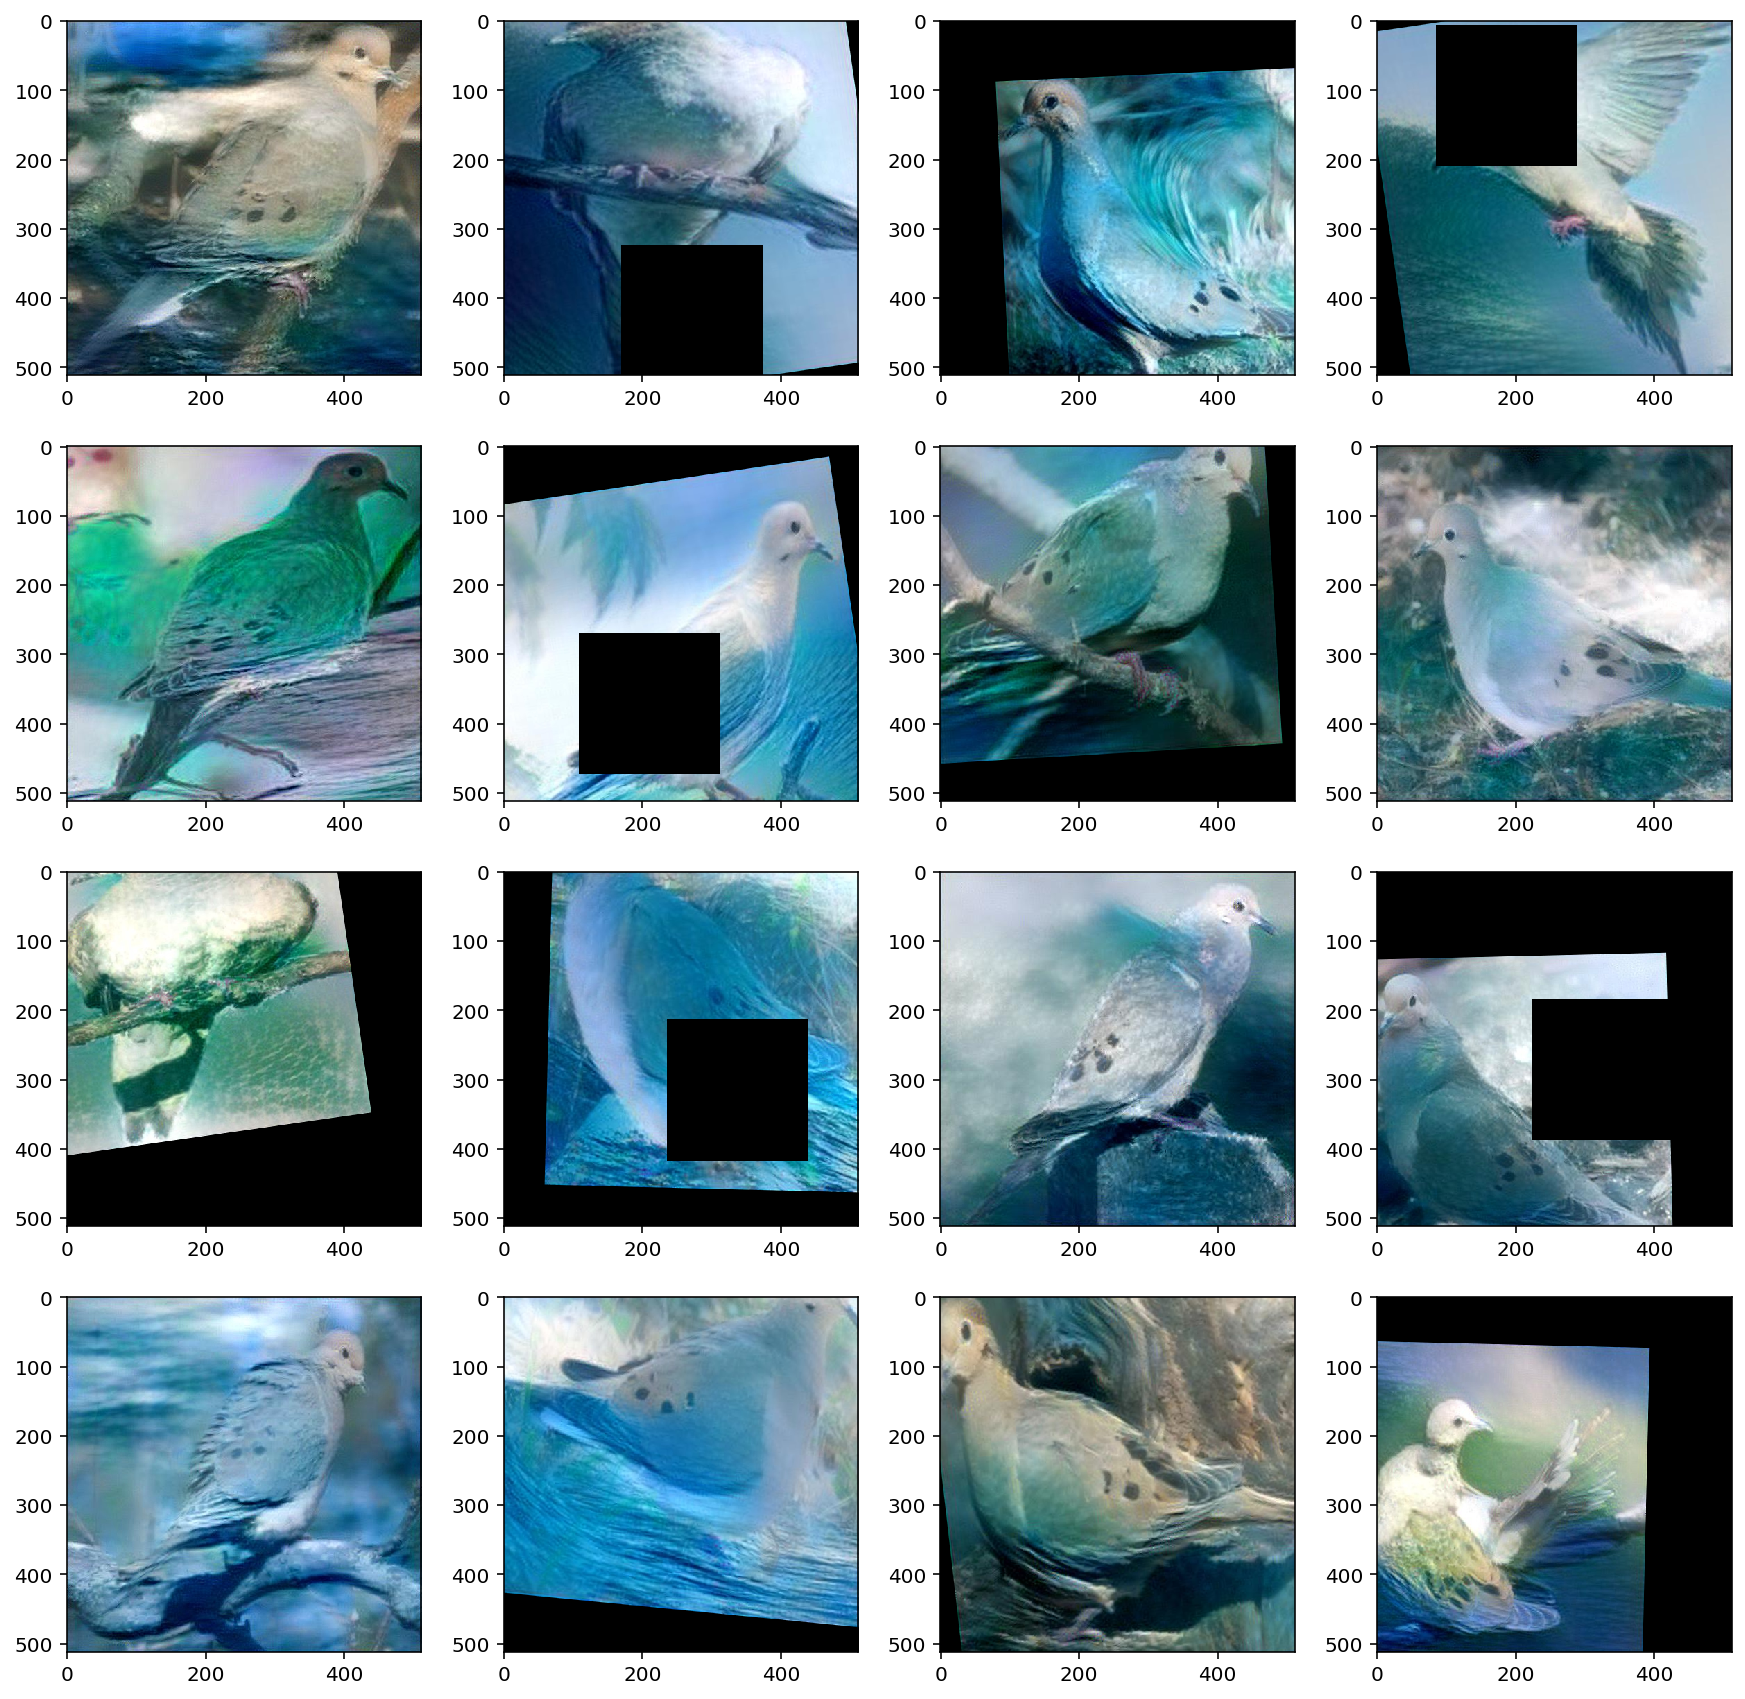

In [12]:
from matplotlib import pyplot as plt
num_im_show=(4,4)
plt.subplots(num_im_show[0], num_im_show[1], figsize=(15,15))
for i in range(num_im_show[0]*num_im_show[1]):
    plt.subplot(num_im_show[0],num_im_show[1],i+1)
    plt.imshow(np.transpose(train_dataset[i][0].type(torch.uint8), (1, 2, 0)), interpolation='nearest')
plt.show()

## Test images

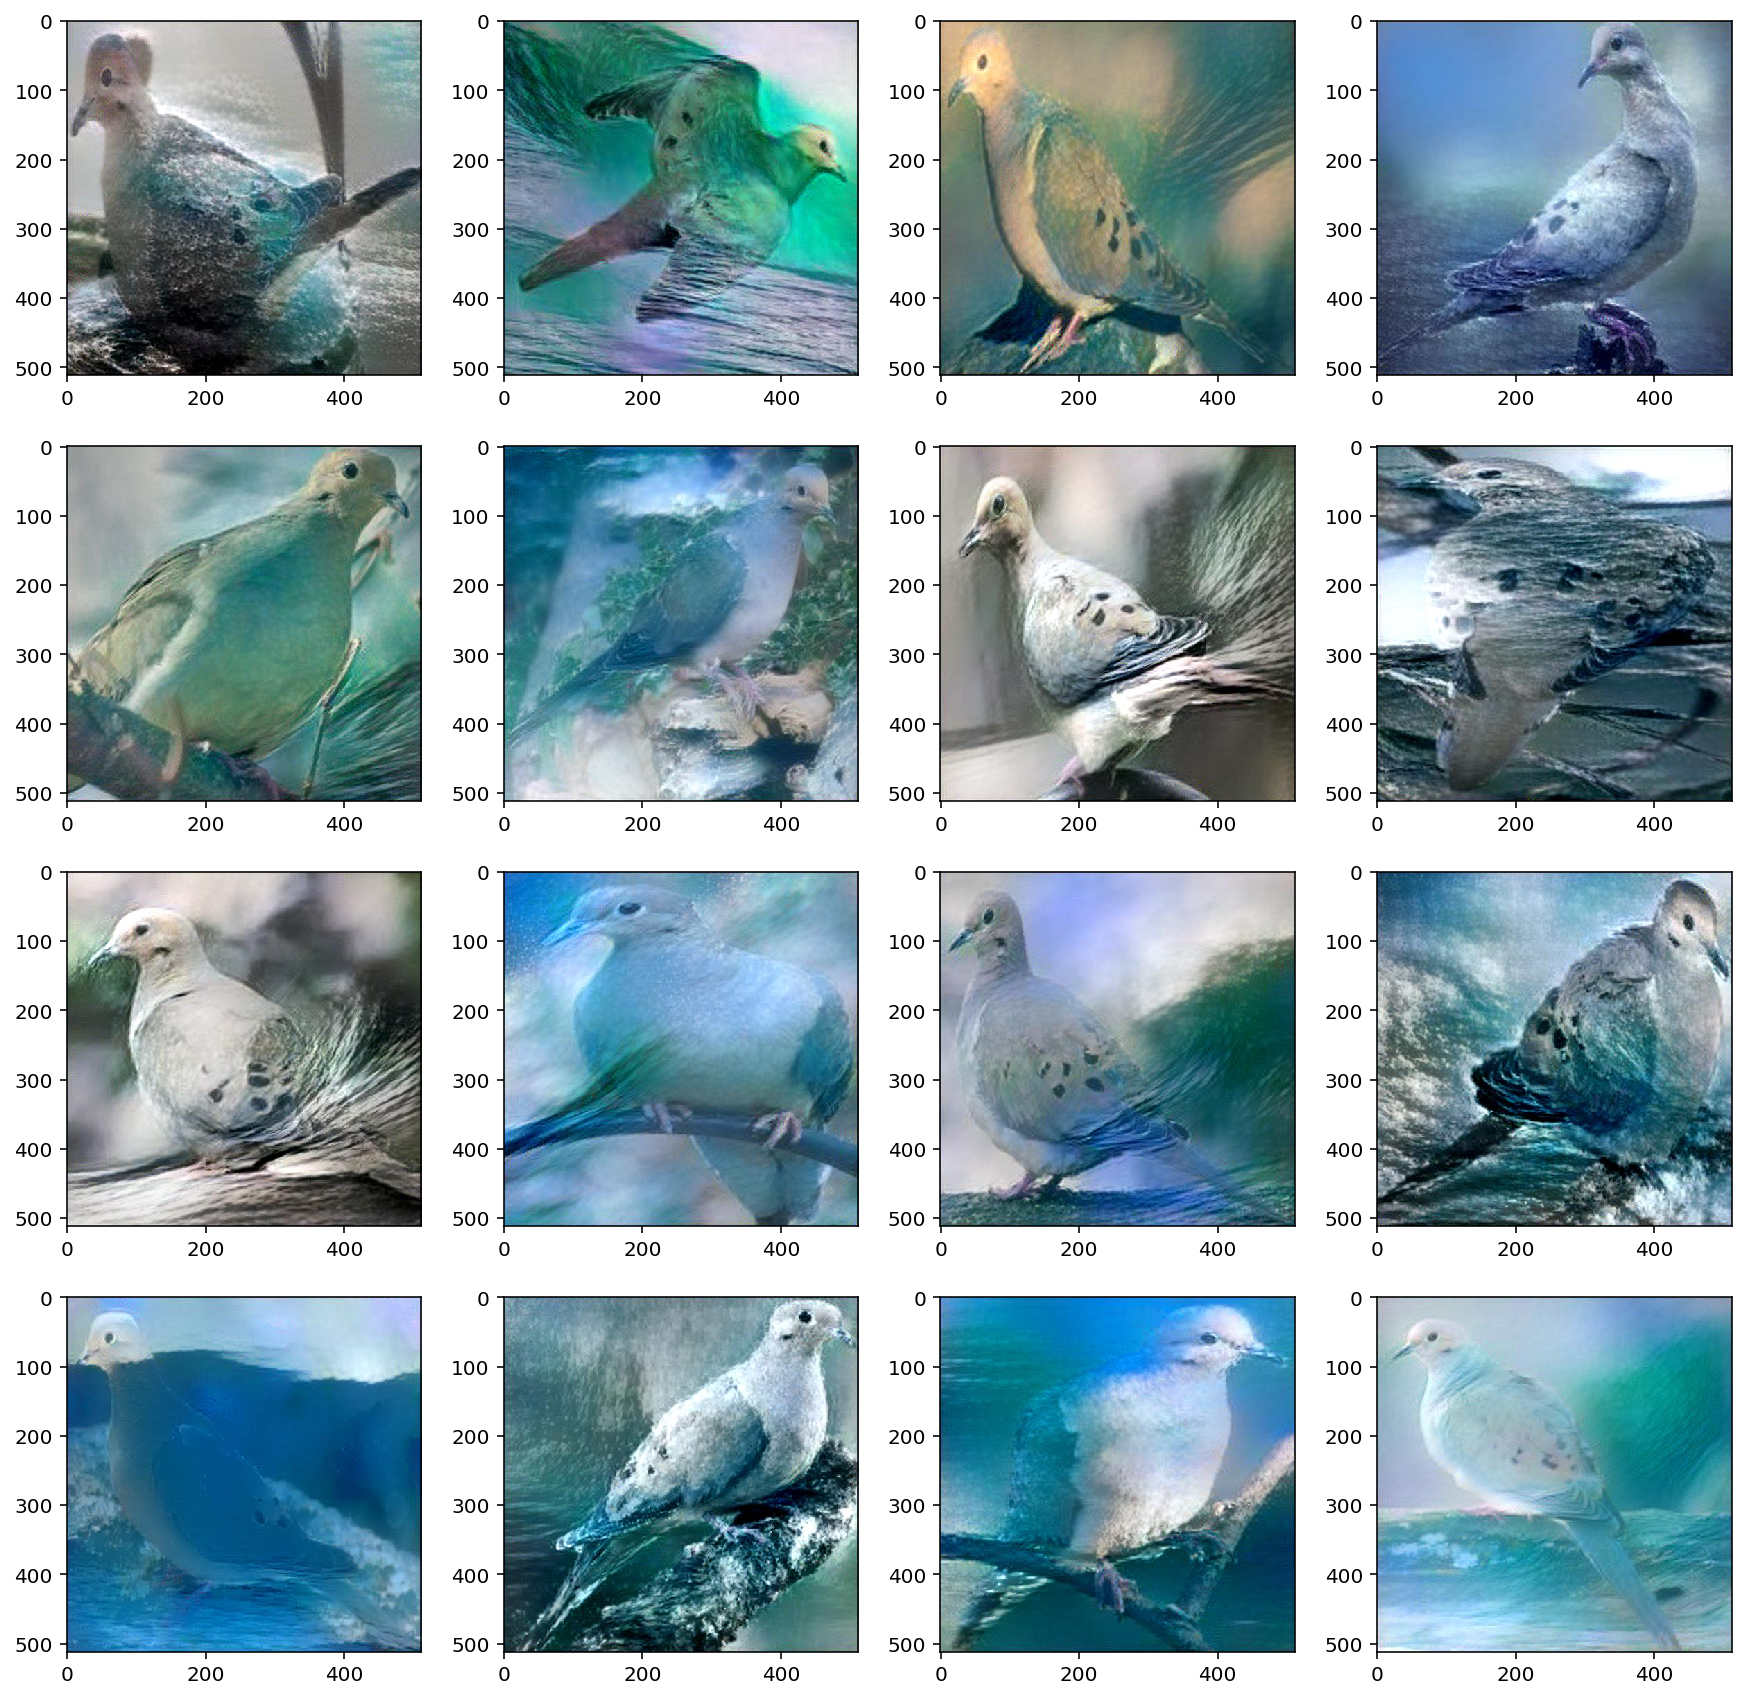

In [13]:
from matplotlib import pyplot as plt
num_im_show=(4,4)
plt.subplots(num_im_show[0], num_im_show[1], figsize=(15,15))
for i in range(num_im_show[0]*num_im_show[1]):
    plt.subplot(num_im_show[0],num_im_show[1],i+1)
    plt.imshow(np.transpose(test_dataset[i][0].type(torch.uint8), (1, 2, 0)), interpolation='nearest')
plt.show()

<div class="alert alert-block alert-success" style="font-size:25px">
     3. Detection model
</div>

Note how we extract 'flatten' layer using introspection capabilities of Pytorch (create_feature_extractor)

In [14]:
class EffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # ---------- EfficientNet v2 ---------- 
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])

        # ---------- Vision Transformer ---------- 
#         self.model = models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1)
        
        # ---------- Resnet ---------- 
#         self.model = models.resnet50(pretrained=True)

        # ---------- VGG19 ---------- 
#         self.model = models.vgg19(pretrained=True)

        self.head = torch.nn.Sequential(
            torch.nn.Linear(1280, len(idx_to_class)),
        )

    def forward(self, x):
        # returns logits
        x = self.model(x)['flatten']
        return self.head(x)

    def predict(self, x):
        pred = self.forward(x)
        return torch.softmax(pred, dim=-1)

# quick test
model = EffnetModel()
model.predict(torch.randn(1, 3, 512, 512))

tensor([[0.3474, 0.3090, 0.3435]], grad_fn=<SoftmaxBackward0>)

In [15]:
del model

<div class="alert alert-block alert-success" style="font-size:25px">
    4. Model training/evaluation
</div>

* We save/load pytorch models manually in `save_model`, `load_model`
* We estimate accuracy metric in `evaluate_segeffnet`
* 5 models are trained in total with GroupKFold.
* OneCycleLR scheduler is used as it is one of the most compute efficient schedulers for 1 epoch training with small amount of data.
* Mixed precision is used to speed up training on Ampere GPUs with fp16.
* wandb inline and remote metrics are generated

In [16]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [17]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [18]:
def save_model(name, model, optim, scheduler):
    torch.save({
        'model': model.state_dict(),
        'optim': optim.state_dict(),
        'scheduler': scheduler
    }, f'{name}.tph')

def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data['model'])
    optim = torch.optim.Adam(model.parameters())
    optim.load_state_dict(data['optim'])
    return model, optim, data['scheduler']

# quick test
model = torch.nn.Linear(2, 1)
optim = torch.optim.Adam(model.parameters())
save_model('testmodel', model, optim, None)

model1, optim1, scheduler1 = load_model(torch.nn.Linear(2, 1), 'testmodel')
assert torch.all(next(iter(model1.parameters())) == next(iter(model.parameters()))).item(), "Loading/saving is inconsistent!"

In [19]:
def evaluate_segeffnet(model: EffnetModel, ds, max_batches=1e9, shuffle=False):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=os.cpu_count(), collate_fn=filter_nones)
    with torch.no_grad():
        model.eval()
        pred = []
        y = []
        progress = tqdm(dl_test, desc='Eval', miniters=100)
        for i, (X, y_vert) in enumerate(progress):
            with autocast():
                y_vert_pred = model.predict(X.to(DEVICE))
            pred.append(y_vert_pred.cpu().numpy())
            y.append(y_vert.numpy())
#             acc = np.mean(pred[-1].argmax(1) == y[-1])
            
            if i >= max_batches:
                break
#         progress.set_description(f'Eval acc: {acc:.02f}')
        pred = np.concatenate(pred)
        y = np.concatenate(y)
        acc = np.mean(pred.argmax(1) == y)
        return acc, pred

In [20]:
def train_segeffnet(ds_train, name):
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), collate_fn=filter_nones)


    model = EffnetModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ONE_CYCLE_MAX_LR, epochs=EPOCHS, steps_per_epoch=min(EFFNET_MAX_TRAIN_BATCHES, len(dl_train)), pct_start=ONE_CYCLE_PCT_START)
    model.train()
    scaler = GradScaler()

    for ep in range(EPOCHS):
        progress = tqdm(dl_train, desc='Train', miniters=10)
        for batch_idx, (X,  y_vert) in enumerate(progress):

#             if batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
#                 eval_loss = evaluate_segeffnet(model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[0]
#                 model.train()
#                 if batch_idx > 0:  # don't save untrained model
#                     save_model(name, model, optim, scheduler)

            if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
                break

            optim.zero_grad()
            with autocast():
                y_vert_pred = model.forward(X.to(DEVICE))
                loss = torch.nn.functional.cross_entropy(y_vert_pred, y_vert.to(DEVICE))

                if np.isinf(loss.item()) or np.isnan(loss.item()):
                    print(f'Bad loss, skipping the batch {batch_idx}')
                    del y_vert_pred, loss
                    gc_collect()
                    continue

            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            scheduler.step()

            progress.set_description(f'Train loss: {loss.item():.02f}')


#         eval_acc, _ = evaluate_segeffnet(model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)
#         model.train()
#         print(f'Eval acc: {eval_acc:.02f}')
    save_model(name, model, optim, scheduler)
    return model

In [21]:
def predict_test(seg_model: EffnetModel):
    ds = test_dataset
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), collate_fn=filter_nones)
    predictions = []
    labels = []
    styles = []
    with torch.no_grad():
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, (X, y, style) in enumerate(progress):
                labels.append(y)
                styles.append(style)
                with autocast():
                    pred = seg_model.predict(X.to(DEVICE))
                    predictions.append(pred)
    predictions = torch.concat(predictions).cpu().numpy()
    labels = torch.concat(labels).cpu().numpy()
    styles = torch.concat(styles).cpu().numpy()
    return predictions, labels, styles

# Training N_TRIALS times

In [22]:
each_trial_heatmap_acc = []

s, c = 3, 3
for n_trial in range(N_TRIALS):
    print(f'Trial {n_trial}:')
    CLASS_NAMES = EACH_TRIAL_CLASS_NAMES[n_trial]
    STYLE_NAMES = EACH_TRIAL_STYLE_NAMES[n_trial]

    
    idx_to_class = {0: CLASS_NAMES[0],
     1: CLASS_NAMES[1],
     2: CLASS_NAMES[2]}
    class_to_idx = {value:key for key,value in idx_to_class.items()}
    
    idx_to_style = {0: STYLE_NAMES[0],
     1: STYLE_NAMES[1],
     2: STYLE_NAMES[2]}
    style_to_idx = {value:key for key,value in idx_to_style.items()}

    train_data, test_data = [], []
    for class_name in CLASS_NAMES:
        for style_name in STYLE_NAMES:
            data_df = pd.read_csv(f'/kaggle/input/kaggle-dataset-stf/{DOMAIN}/{style_name}_{class_name}.csv').sample(frac=1)
            train, test = train_test_split(data_df, test_size=0.5)
            train_data.append(train)
            test_data.append(test)
    train_data = pd.concat(train_data)
    test_data = pd.concat(test_data)

    if WITH_BIAS:
        train_data = bias_spliter(train_data,CLASS_NAMES, STYLE_NAMES,dominant_minority_ratio = 4)

    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)


    #######################################################
    #                  Create Dataset
    #######################################################
    test_image_paths = test_data['FILE_NAME'].values
    test_orig_image_path = test_data['ORIG_CATEGORY_FILE'].values
    test_labels = test_data['CATEGORY'].values
    test_styles = test_data['STYLE'].values
    if WITH_AUGMENTATION:
        test_dataset = AWADataset(test_image_paths,test_orig_image_path,test_labels,test_styles,test_transforms,known_styles=True)
    else:
        test_dataset = AWADataset(test_image_paths,test_orig_image_path,test_labels,test_styles,None,known_styles=True)

    image_paths = train_data['FILE_NAME'].values
    train_orig_image_path = train_data['ORIG_CATEGORY_FILE'].values
    train_labels = train_data['CATEGORY'].values
    train_styles = train_data['STYLE'].values


    seg_model = None
    get_cached_models = False
    fname = os.path.join(f'{EFFNET_CHECKPOINTS_PATH}/trial_{n_trial}/segeffnetv2.tph')
    if os.path.exists(fname):
        print(f'Found cached model {fname}')
        get_cached_models = True
        seg_model = load_model(EffnetModel(), f'segeffnetv2', f'{EFFNET_CHECKPOINTS_PATH}/trial_{n_trial}')[0].to(DEVICE)
    else:
        get_cached_models = False
        gc_collect()

        train_image_paths = image_paths
        
        training_labels = train_labels
        ds_train = AWADataset(train_image_paths,train_orig_image_path,training_labels, train_styles,train_transforms)
        if WITH_AUGMENTATION:
            ds_train = AWADataset(train_image_paths,train_orig_image_path,training_labels, train_styles,train_transforms)
        else:
            ds_train = AWADataset(train_image_paths,train_orig_image_path,training_labels,train_styles, None)

        if not os.path.exists(f'trial_{n_trial}'):
            os.makedirs(f'trial_{n_trial}')
        train_segeffnet(ds_train, f'trial_{n_trial}/segeffnetv2')
        seg_model = load_model(EffnetModel(), f'trial_{n_trial}/segeffnetv2', '.')[0].to(DEVICE)
    
    pred, labels_test, styles_test = predict_test(seg_model)
    acc_test = np.mean(labels_test == pred.argmax(1))
    print(f"Accuracy on test images: {100*acc_test:.3f}%")
    
    heatmap_acc = np.zeros((s,c))
    for class_i in range(c):
        for style_i in range(s):
            test_sample_idx = (labels_test == class_i) * (styles_test == style_i)
            acc_test_group = np.mean(labels_test[test_sample_idx] == pred.argmax(1)[test_sample_idx])
            heatmap_acc[style_i, class_i] = acc_test_group
    each_trial_heatmap_acc.append(heatmap_acc)
    
    def geo_mean(iterable):
        a = np.array(iterable)
        return a.prod()**(1.0/len(a))

    mean_acc_test = np.mean(heatmap_acc.flatten())
    print(f"Group-wise Mean Accuracy on test images: {100*mean_acc_test:.3f}%")
    gmean_acc_test = geo_mean(heatmap_acc.flatten())
    print(f"Group-wise G-Mean Accuracy on test images: {100*gmean_acc_test:.3f}%")
    worst_group_acc_test = np.min(heatmap_acc.flatten())
    print(f"Worst group Accuracy on test images: {100*worst_group_acc_test:.3f}%")
    
    os.remove(f'trial_{n_trial}/segeffnetv2.tph')
    del seg_model, test_dataset, train_data, test_data, data_df, train_labels, test_labels, test_styles, image_paths, test_image_paths
    gc_collect()

Trial 0:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.15it/s]


Accuracy on test images: 75.000%
Group-wise Mean Accuracy on test images: 75.000%
Group-wise G-Mean Accuracy on test images: 74.101%
Worst group Accuracy on test images: 60.000%
Trial 1:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.40it/s]


Accuracy on test images: 69.444%
Group-wise Mean Accuracy on test images: 69.444%
Group-wise G-Mean Accuracy on test images: 68.729%
Worst group Accuracy on test images: 55.000%
Trial 2:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.39it/s]


Accuracy on test images: 88.333%
Group-wise Mean Accuracy on test images: 88.333%
Group-wise G-Mean Accuracy on test images: 88.149%
Worst group Accuracy on test images: 80.000%
Trial 3:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.36it/s]


Accuracy on test images: 76.111%
Group-wise Mean Accuracy on test images: 76.111%
Group-wise G-Mean Accuracy on test images: 75.443%
Worst group Accuracy on test images: 55.000%
Trial 4:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.58it/s]


Accuracy on test images: 76.667%
Group-wise Mean Accuracy on test images: 76.667%
Group-wise G-Mean Accuracy on test images: 75.650%
Worst group Accuracy on test images: 60.000%
Trial 5:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.30it/s]


Accuracy on test images: 89.444%
Group-wise Mean Accuracy on test images: 89.444%
Group-wise G-Mean Accuracy on test images: 89.172%
Worst group Accuracy on test images: 75.000%
Trial 6:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.84it/s]


Accuracy on test images: 69.444%
Group-wise Mean Accuracy on test images: 69.444%
Group-wise G-Mean Accuracy on test images: 69.079%
Worst group Accuracy on test images: 60.000%
Trial 7:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.86it/s]


Accuracy on test images: 70.000%
Group-wise Mean Accuracy on test images: 70.000%
Group-wise G-Mean Accuracy on test images: 67.554%
Worst group Accuracy on test images: 40.000%
Trial 8:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.23it/s]


Accuracy on test images: 93.333%
Group-wise Mean Accuracy on test images: 93.333%
Group-wise G-Mean Accuracy on test images: 93.185%
Worst group Accuracy on test images: 85.000%
Trial 9:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.20it/s]


Accuracy on test images: 65.000%
Group-wise Mean Accuracy on test images: 65.000%
Group-wise G-Mean Accuracy on test images: 64.632%
Worst group Accuracy on test images: 50.000%
Trial 10:


Eval: 100%|██████████| 45/45 [00:03<00:00, 14.80it/s]


Accuracy on test images: 87.222%
Group-wise Mean Accuracy on test images: 87.222%
Group-wise G-Mean Accuracy on test images: 87.090%
Worst group Accuracy on test images: 80.000%
Trial 11:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.32it/s]


Accuracy on test images: 87.778%
Group-wise Mean Accuracy on test images: 87.778%
Group-wise G-Mean Accuracy on test images: 87.615%
Worst group Accuracy on test images: 80.000%
Trial 12:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.74it/s]


Accuracy on test images: 83.333%
Group-wise Mean Accuracy on test images: 83.333%
Group-wise G-Mean Accuracy on test images: 83.102%
Worst group Accuracy on test images: 75.000%
Trial 13:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.89it/s]


Accuracy on test images: 81.111%
Group-wise Mean Accuracy on test images: 81.111%
Group-wise G-Mean Accuracy on test images: 80.814%
Worst group Accuracy on test images: 70.000%
Trial 14:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.65it/s]


Accuracy on test images: 88.333%
Group-wise Mean Accuracy on test images: 88.333%
Group-wise G-Mean Accuracy on test images: 88.149%
Worst group Accuracy on test images: 80.000%
Trial 15:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.40it/s]


Accuracy on test images: 91.667%
Group-wise Mean Accuracy on test images: 91.667%
Group-wise G-Mean Accuracy on test images: 91.546%
Worst group Accuracy on test images: 85.000%
Trial 16:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.49it/s]


Accuracy on test images: 72.222%
Group-wise Mean Accuracy on test images: 72.222%
Group-wise G-Mean Accuracy on test images: 71.012%
Worst group Accuracy on test images: 60.000%
Trial 17:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.48it/s]


Accuracy on test images: 68.333%
Group-wise Mean Accuracy on test images: 68.333%
Group-wise G-Mean Accuracy on test images: 67.988%
Worst group Accuracy on test images: 55.000%
Trial 18:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.18it/s]


Accuracy on test images: 78.333%
Group-wise Mean Accuracy on test images: 78.333%
Group-wise G-Mean Accuracy on test images: 76.512%
Worst group Accuracy on test images: 55.000%
Trial 19:


Eval: 100%|██████████| 45/45 [00:03<00:00, 11.87it/s]


Accuracy on test images: 87.778%
Group-wise Mean Accuracy on test images: 87.778%
Group-wise G-Mean Accuracy on test images: 87.398%
Worst group Accuracy on test images: 70.000%
Trial 20:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.34it/s]


Accuracy on test images: 88.889%
Group-wise Mean Accuracy on test images: 88.889%
Group-wise G-Mean Accuracy on test images: 88.666%
Worst group Accuracy on test images: 75.000%
Trial 21:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.15it/s]


Accuracy on test images: 80.000%
Group-wise Mean Accuracy on test images: 80.000%
Group-wise G-Mean Accuracy on test images: 79.501%
Worst group Accuracy on test images: 65.000%
Trial 22:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.94it/s]


Accuracy on test images: 67.222%
Group-wise Mean Accuracy on test images: 67.222%
Group-wise G-Mean Accuracy on test images: 66.554%
Worst group Accuracy on test images: 50.000%
Trial 23:


Eval: 100%|██████████| 45/45 [00:03<00:00, 12.19it/s]


Accuracy on test images: 69.444%
Group-wise Mean Accuracy on test images: 69.444%
Group-wise G-Mean Accuracy on test images: 68.072%
Worst group Accuracy on test images: 50.000%
Trial 24:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.58it/s]


Accuracy on test images: 75.556%
Group-wise Mean Accuracy on test images: 75.556%
Group-wise G-Mean Accuracy on test images: 75.465%
Worst group Accuracy on test images: 70.000%
Trial 25:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.32it/s]


Accuracy on test images: 78.889%
Group-wise Mean Accuracy on test images: 78.889%
Group-wise G-Mean Accuracy on test images: 78.596%
Worst group Accuracy on test images: 65.000%
Trial 26:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.73it/s]


Accuracy on test images: 93.889%
Group-wise Mean Accuracy on test images: 93.889%
Group-wise G-Mean Accuracy on test images: 93.775%
Worst group Accuracy on test images: 85.000%
Trial 27:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.38it/s]


Accuracy on test images: 67.222%
Group-wise Mean Accuracy on test images: 67.222%
Group-wise G-Mean Accuracy on test images: 65.804%
Worst group Accuracy on test images: 45.000%
Trial 28:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.77it/s]


Accuracy on test images: 73.889%
Group-wise Mean Accuracy on test images: 73.889%
Group-wise G-Mean Accuracy on test images: 73.786%
Worst group Accuracy on test images: 70.000%
Trial 29:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.99it/s]


Accuracy on test images: 90.000%
Group-wise Mean Accuracy on test images: 90.000%
Group-wise G-Mean Accuracy on test images: 89.876%
Worst group Accuracy on test images: 85.000%
Trial 30:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.29it/s]


Accuracy on test images: 90.000%
Group-wise Mean Accuracy on test images: 90.000%
Group-wise G-Mean Accuracy on test images: 89.814%
Worst group Accuracy on test images: 80.000%
Trial 31:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.16it/s]


Accuracy on test images: 83.889%
Group-wise Mean Accuracy on test images: 83.889%
Group-wise G-Mean Accuracy on test images: 83.794%
Worst group Accuracy on test images: 75.000%
Trial 32:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.47it/s]


Accuracy on test images: 87.222%
Group-wise Mean Accuracy on test images: 87.222%
Group-wise G-Mean Accuracy on test images: 86.908%
Worst group Accuracy on test images: 70.000%
Trial 33:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.47it/s]


Accuracy on test images: 84.444%
Group-wise Mean Accuracy on test images: 84.444%
Group-wise G-Mean Accuracy on test images: 84.266%
Worst group Accuracy on test images: 75.000%
Trial 34:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.87it/s]


Accuracy on test images: 90.000%
Group-wise Mean Accuracy on test images: 90.000%
Group-wise G-Mean Accuracy on test images: 89.814%
Worst group Accuracy on test images: 80.000%
Trial 35:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.05it/s]


Accuracy on test images: 86.111%
Group-wise Mean Accuracy on test images: 86.111%
Group-wise G-Mean Accuracy on test images: 85.928%
Worst group Accuracy on test images: 80.000%
Trial 36:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.19it/s]


Accuracy on test images: 72.222%
Group-wise Mean Accuracy on test images: 72.222%
Group-wise G-Mean Accuracy on test images: 71.526%
Worst group Accuracy on test images: 55.000%
Trial 37:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.42it/s]


Accuracy on test images: 83.333%
Group-wise Mean Accuracy on test images: 83.333%
Group-wise G-Mean Accuracy on test images: 82.728%
Worst group Accuracy on test images: 70.000%
Trial 38:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.35it/s]


Accuracy on test images: 87.222%
Group-wise Mean Accuracy on test images: 87.222%
Group-wise G-Mean Accuracy on test images: 86.880%
Worst group Accuracy on test images: 80.000%
Trial 39:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.65it/s]


Accuracy on test images: 90.556%
Group-wise Mean Accuracy on test images: 90.556%
Group-wise G-Mean Accuracy on test images: 90.216%
Worst group Accuracy on test images: 75.000%
Trial 40:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.55it/s]


Accuracy on test images: 91.667%
Group-wise Mean Accuracy on test images: 91.667%
Group-wise G-Mean Accuracy on test images: 91.419%
Worst group Accuracy on test images: 80.000%
Trial 41:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.91it/s]


Accuracy on test images: 61.111%
Group-wise Mean Accuracy on test images: 61.111%
Group-wise G-Mean Accuracy on test images: 60.755%
Worst group Accuracy on test images: 45.000%
Trial 42:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.65it/s]


Accuracy on test images: 84.444%
Group-wise Mean Accuracy on test images: 84.444%
Group-wise G-Mean Accuracy on test images: 84.094%
Worst group Accuracy on test images: 70.000%
Trial 43:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.38it/s]


Accuracy on test images: 86.111%
Group-wise Mean Accuracy on test images: 86.111%
Group-wise G-Mean Accuracy on test images: 85.795%
Worst group Accuracy on test images: 75.000%
Trial 44:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.85it/s]


Accuracy on test images: 75.556%
Group-wise Mean Accuracy on test images: 75.556%
Group-wise G-Mean Accuracy on test images: 75.272%
Worst group Accuracy on test images: 65.000%
Trial 45:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.92it/s]


Accuracy on test images: 76.667%
Group-wise Mean Accuracy on test images: 76.667%
Group-wise G-Mean Accuracy on test images: 76.130%
Worst group Accuracy on test images: 65.000%
Trial 46:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.66it/s]


Accuracy on test images: 83.333%
Group-wise Mean Accuracy on test images: 83.333%
Group-wise G-Mean Accuracy on test images: 83.167%
Worst group Accuracy on test images: 75.000%
Trial 47:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.18it/s]


Accuracy on test images: 62.778%
Group-wise Mean Accuracy on test images: 62.778%
Group-wise G-Mean Accuracy on test images: 61.880%
Worst group Accuracy on test images: 45.000%
Trial 48:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.50it/s]


Accuracy on test images: 88.889%
Group-wise Mean Accuracy on test images: 88.889%
Group-wise G-Mean Accuracy on test images: 88.151%
Worst group Accuracy on test images: 70.000%
Trial 49:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.05it/s]


Accuracy on test images: 91.111%
Group-wise Mean Accuracy on test images: 91.111%
Group-wise G-Mean Accuracy on test images: 90.900%
Worst group Accuracy on test images: 80.000%
Trial 50:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.09it/s]


Accuracy on test images: 58.333%
Group-wise Mean Accuracy on test images: 58.333%
Group-wise G-Mean Accuracy on test images: 57.723%
Worst group Accuracy on test images: 45.000%
Trial 51:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.79it/s]


Accuracy on test images: 75.556%
Group-wise Mean Accuracy on test images: 75.556%
Group-wise G-Mean Accuracy on test images: 74.746%
Worst group Accuracy on test images: 60.000%
Trial 52:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.67it/s]


Accuracy on test images: 90.000%
Group-wise Mean Accuracy on test images: 90.000%
Group-wise G-Mean Accuracy on test images: 89.818%
Worst group Accuracy on test images: 85.000%
Trial 53:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.26it/s]


Accuracy on test images: 90.000%
Group-wise Mean Accuracy on test images: 90.000%
Group-wise G-Mean Accuracy on test images: 89.873%
Worst group Accuracy on test images: 80.000%
Trial 54:


Eval: 100%|██████████| 45/45 [00:03<00:00, 14.92it/s]


Accuracy on test images: 88.889%
Group-wise Mean Accuracy on test images: 88.889%
Group-wise G-Mean Accuracy on test images: 88.738%
Worst group Accuracy on test images: 80.000%
Trial 55:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.19it/s]


Accuracy on test images: 75.556%
Group-wise Mean Accuracy on test images: 75.556%
Group-wise G-Mean Accuracy on test images: 74.366%
Worst group Accuracy on test images: 55.000%
Trial 56:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.79it/s]


Accuracy on test images: 75.556%
Group-wise Mean Accuracy on test images: 75.556%
Group-wise G-Mean Accuracy on test images: 75.122%
Worst group Accuracy on test images: 65.000%
Trial 57:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.55it/s]


Accuracy on test images: 78.889%
Group-wise Mean Accuracy on test images: 78.889%
Group-wise G-Mean Accuracy on test images: 77.361%
Worst group Accuracy on test images: 50.000%
Trial 58:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.83it/s]


Accuracy on test images: 89.444%
Group-wise Mean Accuracy on test images: 89.444%
Group-wise G-Mean Accuracy on test images: 89.338%
Worst group Accuracy on test images: 85.000%
Trial 59:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.97it/s]


Accuracy on test images: 83.889%
Group-wise Mean Accuracy on test images: 83.889%
Group-wise G-Mean Accuracy on test images: 83.640%
Worst group Accuracy on test images: 75.000%
Trial 60:


Train:   0%|          | 0/45 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Eval: 100%|██████████| 45/45 [00:02<00:00, 16.74it/s]


Accuracy on test images: 73.889%
Group-wise Mean Accuracy on test images: 73.889%
Group-wise G-Mean Accuracy on test images: 73.273%
Worst group Accuracy on test images: 55.000%
Trial 61:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.72it/s]


Accuracy on test images: 72.778%
Group-wise Mean Accuracy on test images: 72.778%
Group-wise G-Mean Accuracy on test images: 71.980%
Worst group Accuracy on test images: 55.000%
Trial 62:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.70it/s]


Accuracy on test images: 72.222%
Group-wise Mean Accuracy on test images: 72.222%
Group-wise G-Mean Accuracy on test images: 71.830%
Worst group Accuracy on test images: 60.000%
Trial 63:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.71it/s]


Accuracy on test images: 61.667%
Group-wise Mean Accuracy on test images: 61.667%
Group-wise G-Mean Accuracy on test images: 61.219%
Worst group Accuracy on test images: 50.000%
Trial 64:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.73it/s]


Accuracy on test images: 93.333%
Group-wise Mean Accuracy on test images: 93.333%
Group-wise G-Mean Accuracy on test images: 93.214%
Worst group Accuracy on test images: 85.000%
Trial 65:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.75it/s]


Accuracy on test images: 88.889%
Group-wise Mean Accuracy on test images: 88.889%
Group-wise G-Mean Accuracy on test images: 88.646%
Worst group Accuracy on test images: 80.000%
Trial 66:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.54it/s]


Accuracy on test images: 92.222%
Group-wise Mean Accuracy on test images: 92.222%
Group-wise G-Mean Accuracy on test images: 92.097%
Worst group Accuracy on test images: 85.000%
Trial 67:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.30it/s]


Accuracy on test images: 74.444%
Group-wise Mean Accuracy on test images: 74.444%
Group-wise G-Mean Accuracy on test images: 73.962%
Worst group Accuracy on test images: 55.000%
Trial 68:


Eval: 100%|██████████| 45/45 [00:03<00:00, 13.24it/s]


Accuracy on test images: 90.000%
Group-wise Mean Accuracy on test images: 90.000%
Group-wise G-Mean Accuracy on test images: 89.571%
Worst group Accuracy on test images: 75.000%
Trial 69:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.87it/s]


Accuracy on test images: 80.000%
Group-wise Mean Accuracy on test images: 80.000%
Group-wise G-Mean Accuracy on test images: 79.519%
Worst group Accuracy on test images: 70.000%
Trial 70:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.53it/s]


Accuracy on test images: 90.556%
Group-wise Mean Accuracy on test images: 90.556%
Group-wise G-Mean Accuracy on test images: 90.414%
Worst group Accuracy on test images: 80.000%
Trial 71:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.65it/s]


Accuracy on test images: 84.444%
Group-wise Mean Accuracy on test images: 84.444%
Group-wise G-Mean Accuracy on test images: 84.335%
Worst group Accuracy on test images: 80.000%
Trial 72:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.61it/s]


Accuracy on test images: 80.000%
Group-wise Mean Accuracy on test images: 80.000%
Group-wise G-Mean Accuracy on test images: 79.896%
Worst group Accuracy on test images: 75.000%
Trial 73:


Eval: 100%|██████████| 45/45 [00:04<00:00, 11.22it/s]


Accuracy on test images: 91.667%
Group-wise Mean Accuracy on test images: 91.667%
Group-wise G-Mean Accuracy on test images: 91.510%
Worst group Accuracy on test images: 80.000%
Trial 74:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.83it/s]


Accuracy on test images: 73.889%
Group-wise Mean Accuracy on test images: 73.889%
Group-wise G-Mean Accuracy on test images: 73.507%
Worst group Accuracy on test images: 60.000%
Trial 75:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.84it/s]


Accuracy on test images: 66.667%
Group-wise Mean Accuracy on test images: 66.667%
Group-wise G-Mean Accuracy on test images: 64.963%
Worst group Accuracy on test images: 50.000%
Trial 76:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.92it/s]


Accuracy on test images: 82.778%
Group-wise Mean Accuracy on test images: 82.778%
Group-wise G-Mean Accuracy on test images: 82.050%
Worst group Accuracy on test images: 60.000%
Trial 77:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.85it/s]


Accuracy on test images: 88.333%
Group-wise Mean Accuracy on test images: 88.333%
Group-wise G-Mean Accuracy on test images: 88.207%
Worst group Accuracy on test images: 80.000%
Trial 78:


Eval: 100%|██████████| 45/45 [00:04<00:00, 11.22it/s]


Accuracy on test images: 66.111%
Group-wise Mean Accuracy on test images: 66.111%
Group-wise G-Mean Accuracy on test images: 64.781%
Worst group Accuracy on test images: 45.000%
Trial 79:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.73it/s]


Accuracy on test images: 86.667%
Group-wise Mean Accuracy on test images: 86.667%
Group-wise G-Mean Accuracy on test images: 85.804%
Worst group Accuracy on test images: 65.000%
Trial 80:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.59it/s]


Accuracy on test images: 80.000%
Group-wise Mean Accuracy on test images: 80.000%
Group-wise G-Mean Accuracy on test images: 79.193%
Worst group Accuracy on test images: 65.000%
Trial 81:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.85it/s]


Accuracy on test images: 82.778%
Group-wise Mean Accuracy on test images: 82.778%
Group-wise G-Mean Accuracy on test images: 81.548%
Worst group Accuracy on test images: 55.000%
Trial 82:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.83it/s]


Accuracy on test images: 80.000%
Group-wise Mean Accuracy on test images: 80.000%
Group-wise G-Mean Accuracy on test images: 79.443%
Worst group Accuracy on test images: 65.000%
Trial 83:


Eval: 100%|██████████| 45/45 [00:03<00:00, 11.57it/s]


Accuracy on test images: 91.667%
Group-wise Mean Accuracy on test images: 91.667%
Group-wise G-Mean Accuracy on test images: 91.391%
Worst group Accuracy on test images: 80.000%
Trial 84:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.42it/s]


Accuracy on test images: 92.222%
Group-wise Mean Accuracy on test images: 92.222%
Group-wise G-Mean Accuracy on test images: 92.069%
Worst group Accuracy on test images: 85.000%
Trial 85:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.92it/s]


Accuracy on test images: 92.222%
Group-wise Mean Accuracy on test images: 92.222%
Group-wise G-Mean Accuracy on test images: 92.129%
Worst group Accuracy on test images: 85.000%
Trial 86:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.93it/s]


Accuracy on test images: 89.444%
Group-wise Mean Accuracy on test images: 89.444%
Group-wise G-Mean Accuracy on test images: 89.304%
Worst group Accuracy on test images: 80.000%
Trial 87:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.72it/s]


Accuracy on test images: 87.778%
Group-wise Mean Accuracy on test images: 87.778%
Group-wise G-Mean Accuracy on test images: 87.365%
Worst group Accuracy on test images: 75.000%
Trial 88:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.78it/s]


Accuracy on test images: 73.889%
Group-wise Mean Accuracy on test images: 73.889%
Group-wise G-Mean Accuracy on test images: 73.287%
Worst group Accuracy on test images: 55.000%
Trial 89:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.73it/s]


Accuracy on test images: 89.444%
Group-wise Mean Accuracy on test images: 89.444%
Group-wise G-Mean Accuracy on test images: 88.859%
Worst group Accuracy on test images: 70.000%
Trial 90:


Eval: 100%|██████████| 45/45 [00:03<00:00, 12.40it/s]


Accuracy on test images: 80.000%
Group-wise Mean Accuracy on test images: 80.000%
Group-wise G-Mean Accuracy on test images: 79.547%
Worst group Accuracy on test images: 70.000%
Trial 91:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.80it/s]


Accuracy on test images: 79.444%
Group-wise Mean Accuracy on test images: 79.444%
Group-wise G-Mean Accuracy on test images: 78.979%
Worst group Accuracy on test images: 65.000%
Trial 92:


Eval: 100%|██████████| 45/45 [00:02<00:00, 15.56it/s]


Accuracy on test images: 85.556%
Group-wise Mean Accuracy on test images: 85.556%
Group-wise G-Mean Accuracy on test images: 85.012%
Worst group Accuracy on test images: 65.000%
Trial 93:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.01it/s]


Accuracy on test images: 81.111%
Group-wise Mean Accuracy on test images: 81.111%
Group-wise G-Mean Accuracy on test images: 80.662%
Worst group Accuracy on test images: 65.000%
Trial 94:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.16it/s]


Accuracy on test images: 46.111%
Group-wise Mean Accuracy on test images: 46.111%
Group-wise G-Mean Accuracy on test images: 45.888%
Worst group Accuracy on test images: 40.000%
Trial 95:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.53it/s]


Accuracy on test images: 85.000%
Group-wise Mean Accuracy on test images: 85.000%
Group-wise G-Mean Accuracy on test images: 84.080%
Worst group Accuracy on test images: 60.000%
Trial 96:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.54it/s]


Accuracy on test images: 88.333%
Group-wise Mean Accuracy on test images: 88.333%
Group-wise G-Mean Accuracy on test images: 88.013%
Worst group Accuracy on test images: 75.000%
Trial 97:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.56it/s]


Accuracy on test images: 71.667%
Group-wise Mean Accuracy on test images: 71.667%
Group-wise G-Mean Accuracy on test images: 71.264%
Worst group Accuracy on test images: 60.000%
Trial 98:


Eval: 100%|██████████| 45/45 [00:02<00:00, 16.65it/s]


Accuracy on test images: 72.222%
Group-wise Mean Accuracy on test images: 72.222%
Group-wise G-Mean Accuracy on test images: 70.562%
Worst group Accuracy on test images: 50.000%
Trial 99:


Eval: 100%|██████████| 45/45 [00:03<00:00, 14.65it/s]


Accuracy on test images: 61.667%
Group-wise Mean Accuracy on test images: 61.667%
Group-wise G-Mean Accuracy on test images: 61.254%
Worst group Accuracy on test images: 50.000%


## Heatmap acc

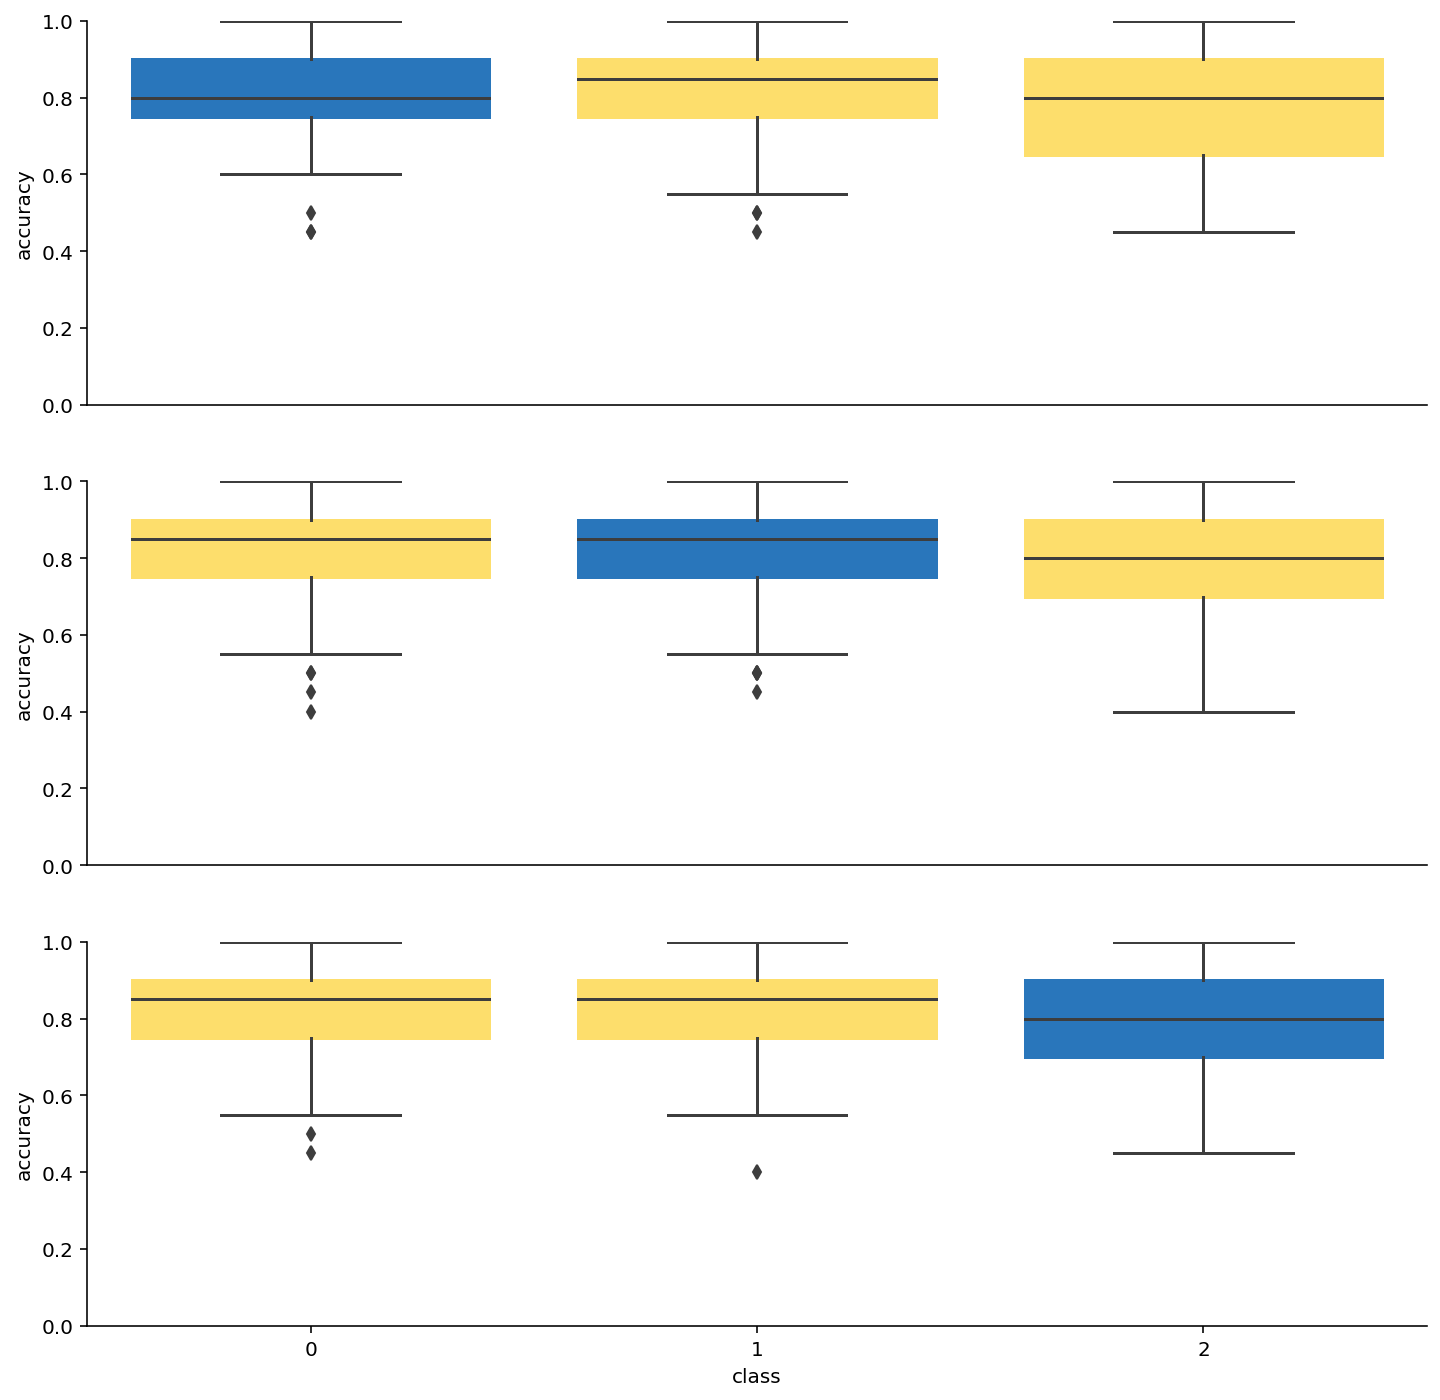

In [23]:
from matplotlib import pyplot as plt
import seaborn as sns
c, s = 3, 3
fig, axes = plt.subplots(s, 1, figsize=(12,12))
# for class_i in range(c):
for style_i in range(s):
    plt.subplot(s,1,style_i+1)
    df = pd.DataFrame({'class':[0]*len(each_trial_heatmap_acc) + \
                       [1]*len(each_trial_heatmap_acc)+\
                       [2]*len(each_trial_heatmap_acc),\
                       'accuracy': [each_trial_heatmap_acc[i][style_i][0] for i in range(len(each_trial_heatmap_acc))]+ \
                                   [each_trial_heatmap_acc[i][style_i][1] for i in range(len(each_trial_heatmap_acc))]+\
                                   [each_trial_heatmap_acc[i][style_i][2] for i in range(len(each_trial_heatmap_acc))]})
    sns.boxplot(data=df, x='class', y='accuracy')
    
#     plt.tick_params(left = False, right = False , labelleft = False ,
#             labelbottom = False, bottom = False) 
    ax = axes[style_i]
    for i,bar in enumerate(ax.patches):
        if i==style_i:
            bar.set_color('#2976bb')    
        else:
            bar.set_color('#fdde6c')
        
    ax.set_ylim([0,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)

    if style_i != s-1:
        ax.axes.get_xaxis().set_visible(False)

plt.show()

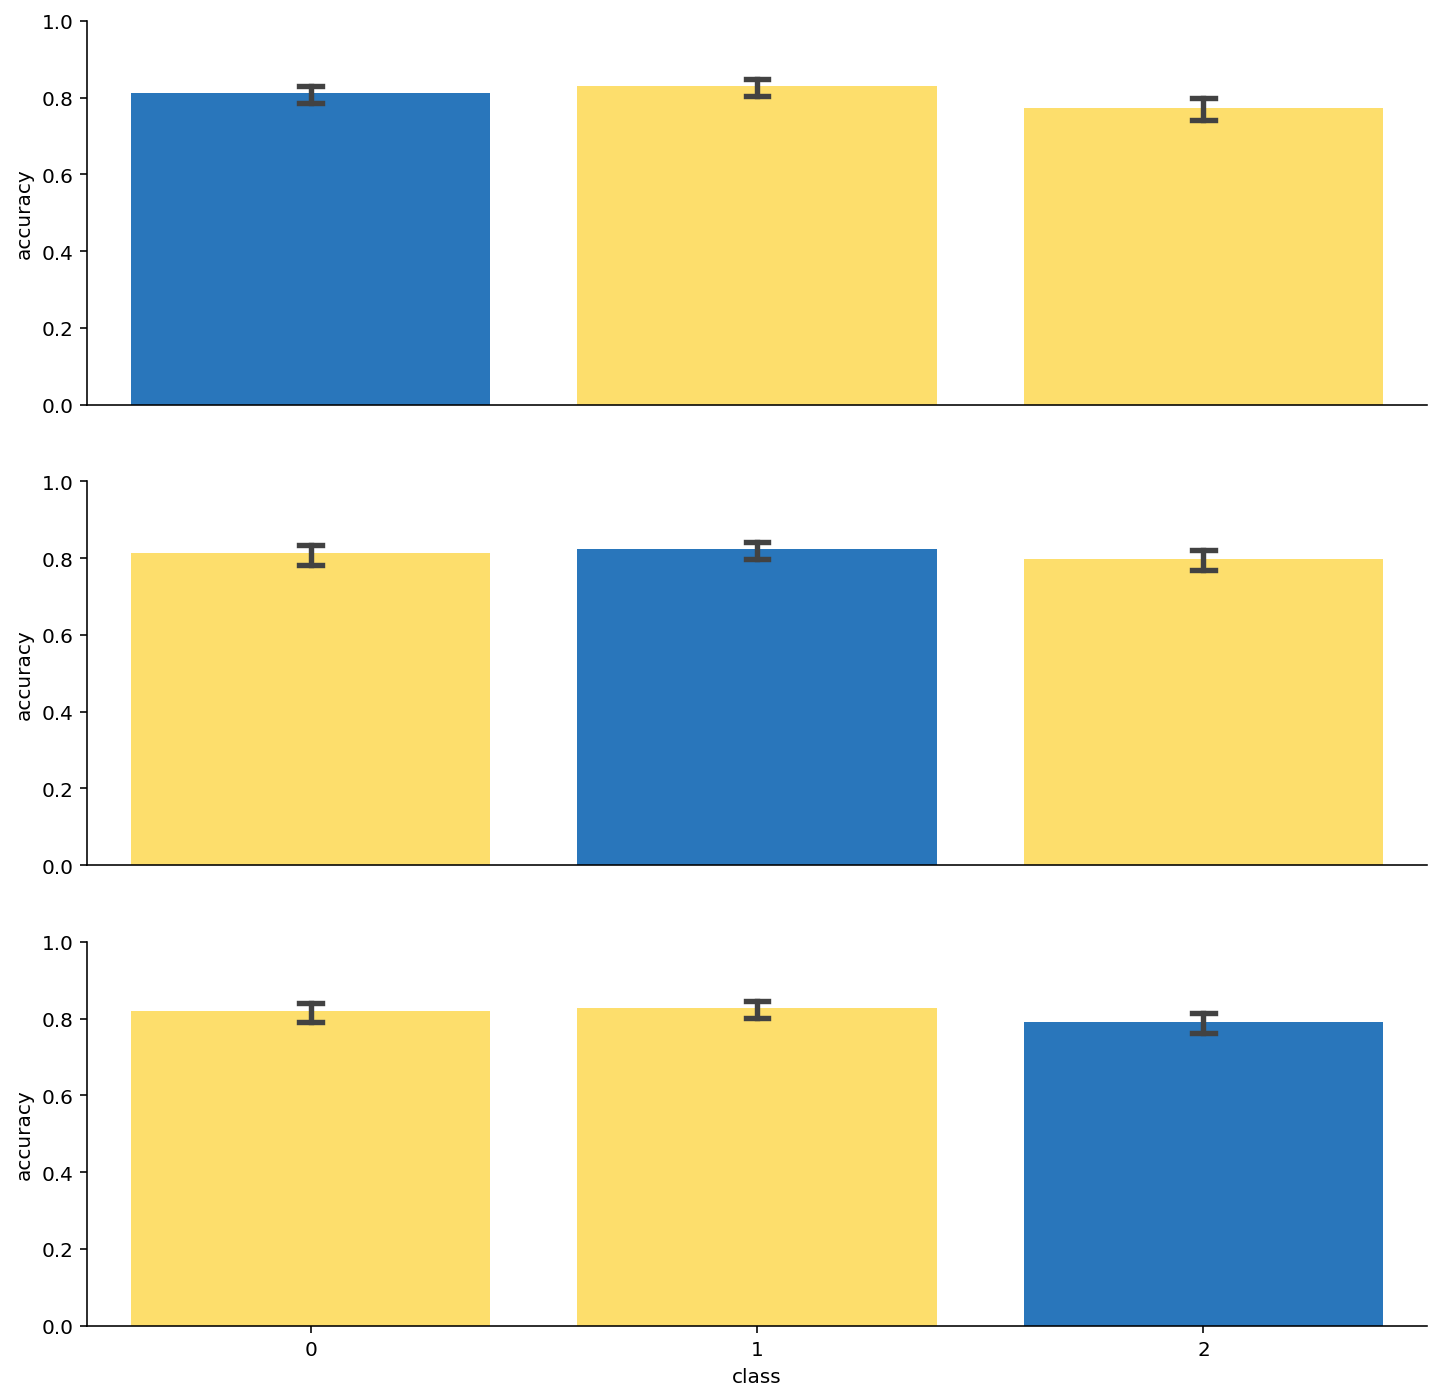

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns
c, s = 3, 3
fig, axes = plt.subplots(s, 1, figsize=(12,12))
# for class_i in range(c):
for style_i in range(s):
    plt.subplot(s,1,style_i+1)
    df = pd.DataFrame({'class':[0]*len(each_trial_heatmap_acc) + \
                       [1]*len(each_trial_heatmap_acc)+\
                       [2]*len(each_trial_heatmap_acc),\
                       'accuracy': [each_trial_heatmap_acc[i][style_i][0] for i in range(len(each_trial_heatmap_acc))]+ \
                                   [each_trial_heatmap_acc[i][style_i][1] for i in range(len(each_trial_heatmap_acc))]+\
                                   [each_trial_heatmap_acc[i][style_i][2] for i in range(len(each_trial_heatmap_acc))]})
    sns.barplot(data=df, x='class', y='accuracy', capsize=0.05)
    
#     plt.tick_params(left = False, right = False , labelleft = False ,
#             labelbottom = False, bottom = False) 
    ax = axes[style_i]
    for i,bar in enumerate(ax.patches):
        if i==style_i:
            bar.set_color('#2976bb')    
        else:
            bar.set_color('#fdde6c')
        
    ax.set_ylim([0,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)

    if style_i != s-1:
        ax.axes.get_xaxis().set_visible(False)

plt.show()

# Save result

In [25]:
all_test_results = (EACH_TRIAL_CLASS_NAMES, EACH_TRIAL_STYLE_NAMES, each_trial_heatmap_acc)

import pickle
with open(f'all_test_results_{DOMAIN}_{USE_ORIGINAL_CONTENT_IMAGES}.pkl', 'wb') as handle:
    pickle.dump(all_test_results, handle, protocol=pickle.HIGHEST_PROTOCOL)